# Synthesize search sessions from signals

This notebook synthesizes search sessions from the CTR of the clicked documents on each search result. It's assumed that if you order results by CTR, that roughly captures the source search system's relevance ranking in aggregate (including all the position and other biases). 

You can then check to see if the document is above or below average for that rank position (using a z score). You can then use that z score to translate that document to any other position. 

This is intended more for creating fake search session data for examples in AI Powered Search, and not a replacement for actually logging real search sessions in your search system.

In [35]:
! cd ../data/retrotech && head signals.csv

import random
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from aips import *
import os
from IPython.core.display import display,HTML

signals = pd.read_csv('../data/retrotech/signals.csv')

seed=8675309
random.seed(seed)
np.random.seed(seed)

NUM_SESSIONS=1000000 # how many sessions to generate?

"query_id","user","type","target","signal_time"
"u2_0_1","u2","query","nook","2019-07-31 08:49:07.3116"
"u2_1_2","u2","query","rca","2020-05-04 08:28:21.1848"
"u3_0_1","u3","query","macbook","2019-12-22 00:07:07.0152"
"u4_0_1","u4","query","Tv antenna","2019-08-22 23:45:54.1030"
"u5_0_1","u5","query","AC power cord","2019-10-20 08:27:00.1600"
"u6_0_1","u6","query","Watch The Throne","2019-09-18 11:59:53.7470"
"u7_0_1","u7","query","Camcorder","2020-02-25 13:02:29.3089"
"u9_0_1","u9","query","wireless headphones","2020-04-26 04:26:09.7198"
"u10_0_1","u10","query","Xbox","2019-09-13 16:26:12.0132"


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Gather queries occuring above a certain threshold

In [36]:
MIN_QUERY_EVENTS=100

queries = signals[signals['type'] == 'query']
popular_queries = queries.groupby('target').count() \
                         .rename(columns={'query_id': 'query_count'}) \
                         .sort_values('query_count', ascending=False)
popular_queries = popular_queries[popular_queries['query_count'] > MIN_QUERY_EVENTS].index.to_list()
pop_query_events = signals[signals['type'] == 'query'][signals['target'].isin(popular_queries)]
query_events = pop_query_events[['query_id', 'target']].rename(columns={'target': 'query'})

# Cleanup by lowercasing
# This step has its pros and cons. We might miss some info that case gives us, but it also
# aggregates more signal per query
query_events['query'] = query_events['query'].apply(lambda q: q.lower())
query_events

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,query_id,query
0,u2_0_1,nook
1,u2_1_2,rca
2,u3_0_1,macbook
3,u4_0_1,tv antenna
6,u7_0_1,camcorder
...,...,...
725452,u744327_0_1,dre beats
725453,u744328_0_1,sirius radio
725455,u744330_0_1,usb drive
725456,u744331_0_1,iphone 4s


# Join click events with corresponding queries into one table

In [37]:
clicks = signals[signals['type'] == 'click']
click_events = clicks[['query_id', 'target']].rename(columns={'target': 'clicked_doc_id'})
clicks_per_query = query_events.merge(click_events, 
                                      on='query_id', 
                                      how='left')
clicks_per_query['clicked_doc_id'] = clicks_per_query['clicked_doc_id'].fillna(0)
# clicks_per_query.groupby('query').count().sort_values('query_id', ascending=False)

clicks_per_query

,query_id,query,clicked_doc_id
0,u2_0_1,nook,9781400532650
1,u2_1_2,rca,883393001119
2,u3_0_1,macbook,885909464036
3,u4_0_1,tv antenna,079000334835
4,u7_0_1,camcorder,027242821866
...,...,...,...
488539,u744327_0_1,dre beats,848447000135
488540,u744328_0_1,sirius radio,884720004032
488541,u744330_0_1,usb drive,718037770604
488542,u744331_0_1,iphone 4s,885909538027


# Compute a CTR for each query/doc pair

0.15889705213356384
0.10964912280701754
0.07842453816660858
0.059931506849315065


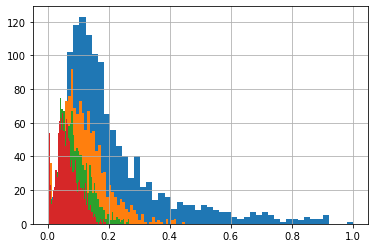

In [38]:
# tot number of queries (denom if CTR)
denominator = query_events.groupby('query').count().rename(columns={'query_id': 'tot_query_count'})

# click counts per doc in query
click_thru_rate = clicks_per_query.groupby(['query', 'clicked_doc_id']).count().rename(columns={'query_id':'click_count'}).reset_index()
click_thru_rate = click_thru_rate.merge(denominator, on='query', how='left')

click_thru_rate['ctr'] = click_thru_rate['click_count'] / click_thru_rate['tot_query_count']
click_thru_rate = click_thru_rate.sort_values(['query', 'ctr'], ascending=[True, False])

# Get rid of doc_id 0, which is all the queries with no clicks
# We treat these as a canonical ranking from the source system, assume it's relatively
# highly tuned and the source CTRs are pretty reasonably close to actual relevance ranking
# in the source system. Of course this is a dubious assumption in a real search system, 
# but for our purposes - to synthesize reasonable looking search sessions - it will serve
canonical_rankings = click_thru_rate[click_thru_rate['clicked_doc_id'] != 0].reset_index()


# Just for display and sanity checking
print(canonical_rankings.groupby('query').nth(0)['ctr'].median())
canonical_rankings.groupby('query').nth(0)['ctr'].hist(bins=50)

print(canonical_rankings.groupby('query').nth(1)['ctr'].median())
canonical_rankings.groupby('query').nth(1)['ctr'].hist(bins=50)

print(canonical_rankings.groupby('query').nth(2)['ctr'].median())
canonical_rankings.groupby('query').nth(2)['ctr'].hist(bins=50)

print(canonical_rankings.groupby('query').nth(3)['ctr'].median())
canonical_rankings.groupby('query').nth(3)['ctr'].hist(bins=50)

# Compute stats of each CTR position

What's the mean, median, std deviaton, etc of CTR in each position? This lets us synthesize sessions assuming the above average or below average CTR is an indication of above or below average relevance

In [39]:
canonical_rankings['rank'] = canonical_rankings.groupby('query').cumcount()

# Idea
# Compute neg z scores for items below mean and positive z scores for items above mean
# but negative z scores are fit to a distribution of only the negative values and the negative values + mean
# similarly for positive values

max_depth = canonical_rankings['rank'].max()
for i in range(0, max_depth):
    idxs = canonical_rankings[canonical_rankings['rank'] == i].index
   
    # Mean based statistics
    canonical_rankings.loc[idxs, 'posn_ctr_mean'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].mean()
    canonical_rankings.loc[idxs, 'posn_ctr_std'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].std()
 
    # Median based statistics (less outlier prone)
    canonical_rankings.loc[idxs, 'posn_ctr_median'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].median()
    canonical_rankings.loc[idxs, 'posn_ctr_mad'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].mad()

canonical_rankings['ctr_std_z_score'] = (canonical_rankings['ctr'] - canonical_rankings['posn_ctr_mean']) / canonical_rankings['posn_ctr_std']
canonical_rankings['ctr_mod_z_score'] = (canonical_rankings['ctr'] - canonical_rankings['posn_ctr_median']) / canonical_rankings['posn_ctr_mad']

canonical_rankings[canonical_rankings['query'] == 'dryer'].head(20)

,index,query,clicked_doc_id,click_count,tot_query_count,ctr,rank,posn_ctr_mean,posn_ctr_std,posn_ctr_median,posn_ctr_mad,ctr_std_z_score,ctr_mod_z_score
15580,15844,dryer,12505451713,20,246,0.081301,0,0.215521,0.172469,0.158897,0.124872,-0.778227,-0.621404
15581,15893,dryer,883929085118,18,246,0.073171,1,0.121488,0.070496,0.109649,0.054231,-0.685393,-0.672647
15582,15887,dryer,883049066905,16,246,0.065041,2,0.087093,0.048757,0.078425,0.038821,-0.452290,-0.344763
15583,15854,dryer,36172950027,13,246,0.052846,3,0.065306,0.036182,0.059932,0.028924,-0.344385,-0.244987
15584,15870,dryer,74108056764,13,246,0.052846,4,0.051849,0.030129,0.048343,0.024117,0.033090,0.186711
15585,15872,dryer,77283045400,13,246,0.052846,5,0.041020,0.024764,0.039578,0.019993,0.477524,0.663618
15586,15883,dryer,783722274422,13,246,0.052846,6,0.031860,0.019346,0.031660,0.015932,1.084741,1.329765
15587,15880,dryer,665331101927,11,246,0.044715,7,0.026049,0.016632,0.025751,0.013968,1.122345,1.357717
15588,15848,dryer,14381196320,9,246,0.036585,8,0.021772,0.014593,0.020859,0.012446,1.015130,1.263529
15589,15871,dryer,74108096487,9,246,0.036585,9,0.018520,0.012575,0.017204,0.010934,1.436546,1.772473


# Create a single search session

Given statistics on CTR, assume the search engine returns a shuffled list of results, and recompute likely CTR for each position. Then randomly select whether there was a click

In [40]:
def synthesize_session(query, sess_id):
    canonical = canonical_rankings[canonical_rankings['query'] == 'iphone']
    shuffled = canonical[['posn_ctr_median', 'posn_ctr_mad', 
                          'posn_ctr_mean', 'posn_ctr_std', 'rank']][canonical['rank'] < 20] \
        .sample(frac=1).rename(columns={'posn_ctr_median': 'dest_ctr_median', 
                                        'posn_ctr_mad': 'dest_ctr_mad',
                                        'posn_ctr_std': 'dest_ctr_std',
                                        'posn_ctr_mean': 'dest_ctr_mean'})
    shuffled.reset_index(drop=True).reset_index().rename(columns={'index': 'rank'})
    shuffled = shuffled.merge(canonical, on='rank', how='left')
    # shuffled['dest_ctr_1'] = (shuffled['ctr_mod_z_score'] * shuffled['dest_ctr_median']) / (shuffled['dest_ctr_mad'])
    shuffled['dest_ctr'] = (shuffled['ctr_std_z_score'] * shuffled['dest_ctr_std']) + (shuffled['dest_ctr_mean'])
    shuffled['clicked'] = np.random.rand(len(shuffled))
    shuffled['clicked'] = shuffled['clicked'] < shuffled['dest_ctr']
    shuffled['sess_id'] = sess_id

    return shuffled

# Randomly sample source signals, generate new sessions

In [41]:
from time import perf_counter 


sessions=pd.DataFrame()
sess_id = 0
rand_queries = queries.sample(frac=1)['target'].to_list()
t1_start = perf_counter()  

while True:
    for q in rand_queries:
        query=q.lower()
        if len(canonical_rankings[canonical_rankings['query'] == query]) > 0:
            sessions = pd.concat([sessions, synthesize_session(query, sess_id)])
            sess_id+=1
            if (sess_id % 500 == 0):
                print("Created Sessions %s Last Query %s Elapsed %s" % (sess_id, query, perf_counter()-t1_start))
    if sess_id > NUM_SESSIONS:
        break


KeyboardInterrupt: 

In [ ]:
all_sessions[all_sessions['query'] == 'dryer']

In [ ]:
all_sessions[['query','sess_id','rank','was_clicked','doc_id']].to_csv('search_sessions.csv')

,dest_ctr_median,dest_ctr_mad,dest_ctr_mean,dest_ctr_std,rank,index,query,clicked_doc_id,click_count,tot_query_count,ctr,posn_ctr_mean,posn_ctr_std,posn_ctr_median,posn_ctr_mad,ctr_std_z_score,ctr_mod_z_score,dest_ctr,clicked
0,0.004902,0.003650,0.007177,0.004475,19,29570,iphone,885909394500,27,2515,0.010736,0.007177,0.004475,0.004902,0.003650,0.795308,1.598137,0.010736,False
1,0.109649,0.054231,0.121488,0.070496,1,29569,iphone,885909394494,164,2515,0.065209,0.121488,0.070496,0.109649,0.054231,-0.798336,-0.819463,0.065209,False
2,0.008439,0.007052,0.011451,0.008090,13,29666,iphone,885909528905,36,2515,0.014314,0.011451,0.008090,0.008439,0.007052,0.353880,0.833194,0.014314,False
3,0.007313,0.006331,0.010445,0.007291,14,29384,iphone,97855069917,31,2515,0.012326,0.010445,0.007291,0.007313,0.006331,0.258040,0.791889,0.012326,False
4,0.020859,0.012446,0.021772,0.014593,8,29662,iphone,885909420438,43,2515,0.017097,0.021772,0.014593,0.020859,0.012446,-0.320334,-0.302213,0.017097,False
5,0.005051,0.004017,0.007613,0.004868,18,29594,iphone,885909538058,28,2515,0.011133,0.007613,0.004868,0.005051,0.004017,0.723147,1.514366,0.011133,False
6,0.025751,0.013968,0.026049,0.016632,7,29395,iphone,600603133237,47,2515,0.018688,0.026049,0.016632,0.025751,0.013968,-0.442565,-0.505676,0.018688,False
7,0.011174,0.008936,0.014300,0.010128,11,29592,iphone,885909538034,39,2515,0.015507,0.014300,0.010128,0.011174,0.008936,0.119204,0.484959,0.015507,False
8,0.158897,0.124872,0.215521,0.172469,0,29529,iphone,843404064434,211,2515,0.083897,0.215521,0.172469,0.158897,0.124872,-0.763176,-0.600616,0.083897,False
9,0.017204,0.010934,0.018520,0.012575,9,29538,iphone,851919003008,42,2515,0.016700,0.018520,0.012575,0.017204,0.010934,-0.144750,-0.046146,0.016700,False
